# HBV Calibration

## Setup and Data Preparation

In [16]:
%matplotlib inline
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import wasserstein_distance

# Niceties
from rich import print
from tqdm import tqdm


# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
from ewatercycle.models import HBV

# Optional: Data Assimilation
# If not installed, uncomment below to install
# !pip install ewatercycle-da
from ewatercycle_DA import DA

## Choose region and time period

<Axes: >

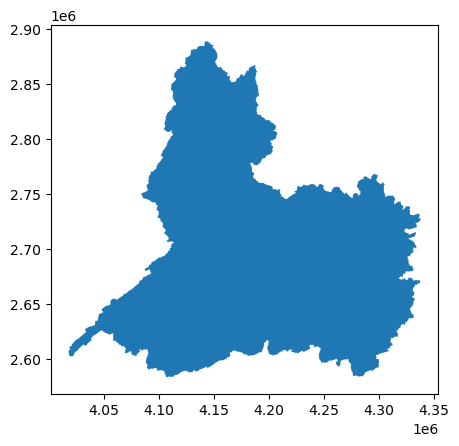

In [2]:
# name of the catchment
basin_name = "FR000119"

# defining dates for calibration
experiment_start_date = "2013-11-26T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

#Define Catchment Area
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"

#check
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
catchment.plot()

In [3]:
# Location forcing files in home directory
forcing_path = Path.home() / "forcing" / "FR000119"/"ERA5"
forcing_path.mkdir(parents=True, exist_ok=True)

## Generate ERA 5 Forcing

In [4]:
# Option one: generate forcing:
#ERA5_forcing = sources["LumpedMakkinkForcing"].generate(
    #dataset="ERA5",
    #start_time=experiment_start_date,
    #end_time=experiment_end_date,
    #shape=shapefile_path,
#)

# Option two: Load generated (merged) data
forcing_dir = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrep5yvtlv4f_20250525_104347/work/diagnostic/script")
ERA5_forcing = sources["LumpedMakkinkForcing"].load(directory=forcing_dir)

## Defining historical data from eStreams
The original CSV file had some formatting and encoding issues—like strange quotation marks and all the data crammed into a single column—which made it impossible to load with the usual pandas.read_csv() method. To work around this, I used a custom parser to manually extract the dates and discharge values.

In [5]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

## Ensemble Initialization and Parameter Sampling

In [6]:
# Define HBV parameter bounds and names
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
p_min = np.array([0.0,  0.2,   40.0,  0.5,   0.001,   1.0,   0.01,  0.0001,  0.01])
p_max = np.array([8.0,  1.0,  800.0,  4.0,   0.3,    10.0,   0.1,   0.01,   10.0])

n_particles = 1000  # ensemble size

# Sample random parameters for each particle within bounds
parameters = np.zeros((len(param_names), n_particles))
for j in range(len(param_names)):
    parameters[j, :] = np.random.uniform(p_min[j], p_max[j], size=n_particles)

In [8]:
# Create ensemble and initialize each member with HBV model and unique parameters
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()  # set up the ensemble environment

# Prepare setup arguments for each particle (each gets its parameter set)
setup_kwargs_list = [{'parameters': parameters[:, i]} for i in range(n_particles)]

# Initialize all ensemble members with the HBVLocal model, forcing data, and parameters
ensemble.initialize(model_name=["HBVLocal"] * n_particles,
                    forcing=[ERA5_forcing] * n_particles,
                    setup_kwargs=setup_kwargs_list) 

# Choose a reference model for time tracking
ref_model = ensemble.ensemble_list[0].model

# Generate config file with first parameter set
config_file, _ = ref_model.setup(parameters=parameters[:, 0])

# Initialize model
ref_model.initialize(config_file)

In [9]:
# deleta all unnescessary files, Watchout with this!!!
# import shutil
# from pathlib import Path

# # Search for all folders starting with "hbvlocal_"
# work_dir = Path(".")
# folders = [f for f in work_dir.glob("hbvlocal_*") if f.is_dir()]

# # Delete them all
# for folder in folders:
#     print(f"Delete: {folder}")
#     shutil.rmtree(folder)

## Running the Ensemble Simulation

In [10]:
# Determine number of time steps in the simulation period
n_timesteps = int((ref_model.end_time - ref_model.start_time) / ref_model.time_step)

time_index = []           # list to store timestamps for each time step
ensemble_Q_outputs = []   # list to store discharge arrays for each time step

for step in range(n_timesteps):
    # Record current model time
    current_time = pd.Timestamp(ref_model.time_as_datetime.date())
    time_index.append(current_time)
    
    # Advance all models by one time step and collect their discharge values
    ensemble.update()  # update all ensemble members by one step
    Q_values = np.array(ensemble.get_value("Q")).flatten()  # discharge of all particles
    Q_values_m3s = Q_values * basin_area * 1000 / 86400 #convert to m3/s
    ensemble_Q_outputs.append(Q_values_m3s)

# Finalize the ensemble to release resources
ensemble.finalize()

# Convert collected outputs to a DataFrame for convenience
Q_array = np.array(ensemble_Q_outputs)        # shape: (n_timesteps, n_particles)
df_ensemble = pd.DataFrame(
    data=Q_array, 
    index=pd.DatetimeIndex(time_index), 
    columns=[f"particle_{i}" for i in range(n_particles)]
)

In [11]:
print(df_ensemble.shape)
print(df_ensemble.head())

(2555, 1000)

particle_0  particle_1  particle_2  particle_3  particle_4  \
2013-01-01    0.000031    0.000000    0.005173    0.000018    0.000674   
2013-01-02    0.006097    0.000049    0.025426    0.016131    0.138722   
2013-01-03    0.023692    0.000244    0.055979    0.063487    0.273492   
2013-01-04    0.083401    0.004950    0.092711    0.181193    0.689728   
2013-01-05    0.264369    0.050217    0.144993    0.450459    1.627383   

            particle_5  particle_6  particle_7  particle_8  particle_9  ...  \
2013-01-01    0.000612    0.000028    0.000000    0.000002    0.000135  ...   
2013-01-02    0.006413    0.001476    0.000586    0.000010    0.001198  ...   
2013-01-03    0.022200    0.005712    0.002924    0.000030    0.004226  ...   
2013-01-04    0.064091    0.016991    0.036716    0.000070    0.010022  ...   
2013-01-05    0.172354    0.045285    0.188905    0.000141    0.021437  ...   

            particle_990  particle_991  particle_992  particle_993  \
2013-01-01      0.000007      0.000128      0.000038      0.000000   
2013-01-02      0.010975      0.000727      0.027168      0.000008   
2013-01-03      0.043501      0.002200      0.106441      0.000042   
2013-01-04      0.143951      0.005167      0.303352      0.016255   
2013-01-05      0.418614      0.010495      0.866135      0.099217   

            particle_994  particle_995  particle_996  particle_997  \
2013-01-01      0.000185  0.000000e+00      0.000000      0.000026   
2013-01-02      0.000920  4.690262e-07      0.000074      0.000165   
2013-01-03      0.002053  2.344535e-06      0.000370      0.000534   
2013-01-04      0.003438  8.147060e-06      0.493454      0.001344   
2013-01-05      0.005435  2.377485e-05      2.647484      0.003028   

            particle_998  particle_999  
2013-01-01      0.000550      0.000098  
2013-01-02      0.003196      0.000666  
2013-01-03      0.009913      0.001817  
2013-01-04      0.023234      0.005467  
2013-01-05      0.045325      0.028389  

[5 rows x 1000 columns]

## Defining the Calibration Objective

In [12]:
def calibration_objective(simulated_series: pd.Series, observed_series: pd.Series) -> float:
    """
    Compute the calibration objective for a single model run by comparing 
    simulated and observed discharge series. The objective combines:
      - RMSE on days with observed flow < 500 m³/s
      - EMD between distributions of drought event durations
      - EMD between distributions of drought event cumulative deficits
    Lower values indicate a better fit to observations.
    """
    # Align simulated series with observed series index
    sim = simulated_series.loc[observed_series.index]
    obs = observed_series

    # 1. RMSE for days with observed discharge < 500 m³/s
    low_flow_mask = obs < 500.0
    if low_flow_mask.sum() == 0:
        rmse_low_flow = 0.0  # no low-flow days, no penalty
    else:
        errors = sim[low_flow_mask] - obs[low_flow_mask]
        rmse_low_flow = np.sqrt(np.mean(errors**2))

    # 2. EMD between drought event durations
    # Identify drought events in observed and simulated series
    obs_droughts = droughts(obs, basin_name="obs", q_crit=500)
    sim_droughts = droughts(sim, basin_name="sim", q_crit=500)
    # Convert to DataFrame for
    obs_droughts_df = pd.DataFrame(obs_droughts)
    sim_droughts_df = pd.DataFrame(sim_droughts)
    # Extract durations of each drought event
    obs_durations = obs_droughts_df["Duration (days)"].values
    sim_durations = sim_droughts_df["Duration (days)"].values
    # Compute EMD (Wasserstein distance) between duration distributions
    emd_duration = wasserstein_distance(obs_durations, sim_durations)

    # 3. EMD between drought cumulative deficits
    # Extract the maximum cumulative deficit of each drought event (most negative deficit)
    obs_deficits = obs_droughts_df["Max Cumulative Deficit (m3/s)"].values
    sim_deficits = sim_droughts_df["Max Cumulative Deficit (m3/s)"].values
    #Cconvert negative values to positive magnitudes for comparison
    obs_deficits = -obs_deficits
    sim_deficits = -sim_deficits
    # Compute EMD between deficit distributions
    emd_deficit = wasserstein_distance(obs_deficits, sim_deficits)

    # Combine the three components into a single score
    total_score = rmse_low_flow + emd_duration + emd_deficit
    return total_score

In [13]:
print("Q_obs index sample:", Q_obs.index[:3])
print("df_ensemble index sample:", df_ensemble.index[:3])

Q_obs index sample: DatetimeIndex(['2013-11-26 00:00:00+00:00', '2013-11-27 00:00:00+00:00',
               '2013-11-28 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

df_ensemble index sample: DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03'], dtype='datetime64[ns]', 
freq=None)

## Evaluating Performance and Selecting the Best Parameter Set

In [14]:
from critical_days_module import droughts

Exported functions to: critical_days_module.py


In [1]:
# Evaluate objective for each ensemble member
scores = []

# Same datetime-index
Q_obs.index = Q_obs.index.normalize()
Q_obs.index = Q_obs.index.tz_localize(None)

# Slice only the overlap 
Q_obs_aligned = Q_obs.loc[df_ensemble.index.min():df_ensemble.index.max()]

for i in range(n_particles):
    sim_series = df_ensemble[f"particle_{i}"]

    if sim_series is None or sim_series.empty:
        print(f"Skipping particle_{i} (empty output)")
        scores.append(np.inf)  # Assign a bad score
        continue

    # Use the correct observation series (make sure Q_obs exists and matches in index)
    score = calibration_objective(sim_series, Q_obs_aligned)
    scores.append(score)

scores = np.array(scores)
best_index = np.argmin(scores)              # index of minimum objective value
best_score = scores[best_index]             # lowest score
best_params = parameters[:, best_index]     # parameter set corresponding to best score

print(f"Best score: {best_score:.3f} (part {best_index})")

NameError: name 'Q_obs' is not defined

In [18]:
print("Number of scores:", len(scores))
print("First 5 scores:", scores[:5])

Aantal scores: 1000

Eerste 5 scores: [ 2337.02408574  1847.55440469 10368.85292768  2977.28651546
  4202.46654696]

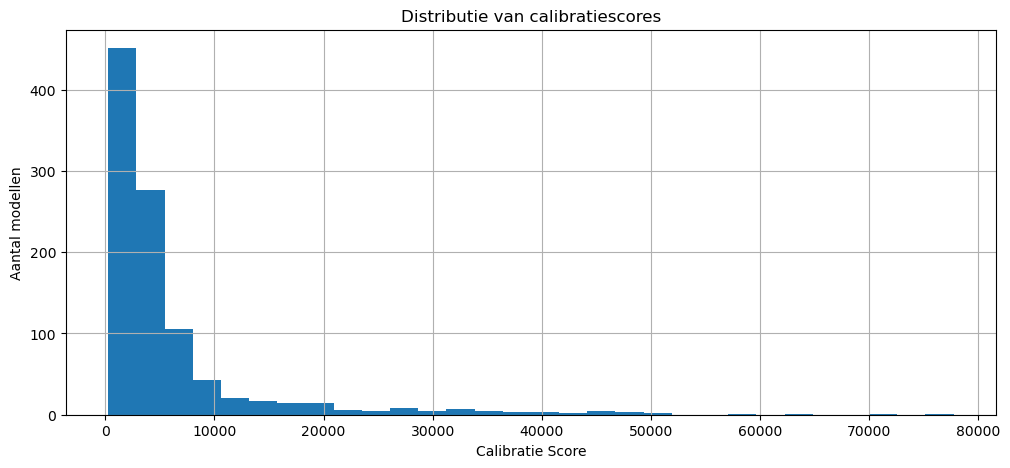

Beste score: 261.035 bij particle index: 298

In [19]:
# Histogram of scores
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(scores, bins=30)
plt.title("Distributie van calibratiescores")
plt.xlabel("Calibratie Score")
plt.ylabel("Aantal modellen")
plt.grid(True)
plt.show()

# Print best score
print(f"Best score: {best_score:.3f} at particle index: {best_index}")

## Outputting the Optimal Parameters

In [20]:
# Print the best score and parameter
print(f"Best objective score: {best_score:.4f}")
best_params_list = [round(val, 4) for val in best_params]
print("par_0 =", best_params_list)
print("param_names =", param_names)

Best objective score: 261.0352

par_0 =
[3.0921, 0.928, 131.8813, 3.7768, 0.0578, 5.6994, 0.0168, 0.0002, 1.4708]

param_names =
['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']